# 第三週：基本的文字資料的處理(英文)
**Author:** 張芳瑜<br>
**Date created:** 2021/09/21<br>
**Last modified:** 2021/10/03<br>

本週課程為「基本的文字資料的處理」，目的為了解基本的文字處理概念。文字處理的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的文字處理過程，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、Tidy Data、文字處理的基本概念、文字處理的實際應用等四個部分。

## 大綱
1. 套件說明
2. Tidy Data
3. 文字處理基本流程
    - 3.1. 建立英文文件範例
    - 3.2. 斷句斷詞
    - 3.3. 移除停用字
    - 3.4. 字詞正規化
4. 實際應用
    - 4.1. 資料清理
    - 4.2. 視覺化結果

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。

- Pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [1]:
# colab install guide
# %pip install wordcloud

In [2]:
# 確認當前目錄
%pwd

'/home/skypc785308/SMA_2021F/week3_tidy_data'

In [2]:
# 載入套件
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.corpus import gutenberg
from nltk import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud # pip install wordcloud
import matplotlib.pyplot as plt



# 下載文集
# nltk.download('gutenberg')
# 下載斷句需要的資源
# nltk.download('punkt')
# 下載POS tagger需要的資源
# nltk.download('averaged_perceptron_tagger')

In [3]:
# 設定圖的字體
plt.rcParams['font.size'] = 14

## 2. Tidy Data
在進行資料分析的過程當中，資料清理是一個不可或缺的環節，資料清理的精細程度也會直接影響結果好壞。而在機器學習的領域當中，我們通常會將文字型資料(Textual Data)視為是一種非結構化資料(Unstructure Data)。這樣的非結構化資料是需要透過特定的清理方式將其轉為結構化資料之後，才能夠為後續分析使用。這樣的處理方式我們將其稱為Data Tidying。而處理過後的「乾淨」的資料，我們就把它叫做Tidy Data。其定義的原則如下：

1. 每個變數分別在個別的欄位。
2. 每筆觀察值形成一列。
3. 不同主題要用不同table來整理。

接著我們用一個範例來介紹Tidy Data。

下面圖片中的兩個表格是使用相同的資料，但不同的表達方式。其概念都是要用來描述不同的人(person)在不同的實驗(treatmenta, treatmentb)當中的結果(表格中的數字)。

<img src="./pic/untidy.png" alt="untidy_table" width="400"/>

而這樣的資料其實是不利於資料分析的進行的。我們用剛才所定義的原則來將資料轉換為Tidy Data(如下圖中的表格)，可以看到資料其實是包含了三個變數、六個觀察值。也就是說我們可以用一個Pandas的DataFrame來表達資料。

<img src="./pic/tidy_table.png" alt="tidy_table" width="400"/>

在Python中的資料表可使用Pandas DataFrame儲存，Pandas套件也提供了許多的函數可以進行資料的轉換與操作

有關DataFrame的操作可參考Pandas官網的[教材](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html)

## 3. 文字處理基本流程
接下來的章節我們將介紹文字處理的基本流程。其中大概可以分為六個步驟

+ 資料蒐集: 如同上面所述，文字型資料被視為是一種非結構化的資料。其資料來源相當的廣泛，如：論壇、新聞網、社群媒體、專利、論文等...。其中，論壇、新聞網、社群媒體這類由使用者所產生出來的資料我們將其稱為User Generated Data(UGC)。通常來說，我們會使用網路爬蟲的技術來取得這樣的資料(網路爬蟲的技術不會在此範例中討論)。在後續的範例中，我們將使用不同的文字資料集來說明文字分析的技術。
+ 資料初步清理: 將文字內容轉為正規的語句，例如：去除特定標籤、符號、統一標點符號的使用等等
+ 斷句斷詞: 使用工具區隔文章中不同的句子、詞彙
+ 去除停用字: 停用字就是與分析無關的詞彙，甚至這些詞彙可能會影響分析的結果。因此我們必須在資料處理的過程中將其排除。例如：語助詞
+ 產生結構化資料: 根據需求產生不同結構化資料(Tidy Data)，以供後續分析使用。
+ 應用更多分析: 進行不同的分析，例如：情緒分析、詞頻分析

以下，我們會利用一個文件的範例來說明文字處理的流程。

### 3.1 建立英文文件（English_text）
我們建立一個範例文件(Document)，並將其用Python中的String物件儲存。這也是我們用來進行文字分析的最小單位。一個文件可能是一篇論壇的討論串、一則社群媒體的貼文、一篇新聞、或者可能只是某篇文章中的一個段落、甚至是一句話。這完全取決於分析層級的不同，由使用者自行定義。許多文件組合在一起形成的資料集合我們稱為文集(Corpus)。在這範例當中，我們將*english_text*物件定義為一個歌詞的段落。

In [4]:
# 多行字串使用 """
english_text = """Because of you
I never stray too far from the sidewalk.
Because of you
I learned to play on the safe side so I don’t get hurt."""

### 3.2 斷句斷詞

由於這個簡單範例中並沒有需要特別清理的部份，我們將略過「資料初步清理」的階段，直接進行「斷句斷詞」。觀察上面的範例文件，我們可以看到其中包含了四行文字。在這裡使用Python String物件內建的splitlines()的函式將字串依照換行符號切割。結果存在*text_split*這個Python List中。依據不同的資料內容，需要考慮不同的、甚至是多個斷句符號。

In [5]:
text_split = english_text.splitlines()
text_split

['Because of you',
 'I never stray too far from the sidewalk.',
 'Because of you',
 'I learned to play on the safe side so I don’t get hurt.']

In [6]:
# NLTK套件斷句方法
# 在NLTK中有個nltk.sent_tokenize()函式可提供斷句功能，針對英文的標點符號有特殊處理
# 下面的例句當中可以看到英文中的「.」會被用於句子的結束(句號)，但同時也可能是用來表示縮寫(如：U.S.)
print('NLTK能夠處理英文標點符號問題:')
print(nltk.sent_tokenize("I went to the U.S. last summer. It is one of the best memories of my life."))

# 但是針對某些特殊字元(如：換行符號, \n)，NLTK套件並不會將其分句
text_split = nltk.sent_tokenize(english_text)
print('NLTK不會處理\\n等特殊字元:')
print(text_split)

# 觀察資料後，我們將「\n」字元轉換成「,」
text_split = [x.replace('\n', ', ') for x in text_split]
print('完整清理斷句後的結果:')
print(text_split)

NLTK能夠處理英文標點符號問題:
['I went to the U.S. last summer.', 'It is one of the best memories of my life.']
NLTK不會處理\n等特殊字元:
['Because of you\nI never stray too far from the sidewalk.', 'Because of you\nI learned to play on the safe side so I don’t get hurt.']
完整清理斷句後的結果:
['Because of you, I never stray too far from the sidewalk.', 'Because of you, I learned to play on the safe side so I don’t get hurt.']


再來我們將建立出一個Pandas DataFrame的物件來儲存資料，這裡用Python Dict來建立DataFrame。Dict裡的key值(下面的line、text)對應到一個欄位的名稱，而其值(value)則是其欄位裡的所有值。
在*text_df*中我們可以看到一個完整的斷句結果，其中包含了兩個英文句子。

In [7]:
text_df = {
    "line" : range(1,len(text_split)+1), #行數
    "text" : text_split #句子(list)
}
text_df = pd.DataFrame(text_df) #後面是字典或是陣列
text_df

,line,text
0,1,"Because of you, I never stray too far from the..."
1,2,"Because of you, I learned to play on the safe ..."


在英文的文字分析當中，斷詞相對於中文是更簡單的。通常只需要使用空白符號(White Space)即可將不同字詞(Token)分開。這裡使用NLTK套件當作斷詞系統的範例，並將文件整理成我們要的Tidy Data格式。步驟解釋如下：
+ assign : 新增一個欄位「word」，值為text_df['text']進行nltk_word_tokenize的結果
+ explode : word_tokenize的結果為list，因此用explode將list裡的每個值變單獨一行
+ drop : 將欄位「text」刪除，axis=0為對縱軸操作(column)，axis=1為對橫軸操作(row)

In [8]:
token_df = text_df.assign(word = text_df['text'].apply(nltk.word_tokenize)).explode('word').drop(['text'], axis=1)
token_df

,line,word
0,1,Because
0,1,of
0,1,you
0,1,","
0,1,I
0,1,never
0,1,stray
0,1,too
0,1,far
0,1,from


### 3.3 移除停用字（無意義字、標點符號）

停用字(Stopwords)是指那些對於分析沒有用的字詞，通常在進行文字分析時我們會將其去除，以避免一些雜訊的產生。這裡我們使用了NLTK套件中所提供的英文停用字資料來進行移除停用字的依據。初次使用的時候可以用以下的程式來下載預設停用字、或者是可以加入一些自訂的停用字詞。

In [9]:

# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')

# nltk的stop_words
stop_words = stopwords.words('english') 

#手動加入
stop = ['--','",','."',',"','?"','!"','’']
stop_words.extend(stop)

stop_words = set(stop_words) ## 使用set物件來儲存，可以提升後續的比對效率
# print(stop_words)

[nltk_data] Downloading package stopwords to /home/k8sn2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


而移除停用字的方式是依照條件來篩選資料：*token_df['word']* 沒有在停用字裡，這邊要特別注意的是要先做字詞的正規化(Text Normalization)，我們將文字都先轉成小寫英文再來進行比對，否則有些字不會被去除。例如：I、Because...

結果如下，比較上一個DataFrame可以發現，留下來的字是更具有意義的。

In [10]:
token_df = token_df[(token_df['word'].str.lower().isin(stop_words) == False)]
token_df

,line,word
0,1,","
0,1,never
0,1,stray
0,1,far
0,1,sidewalk
0,1,.
1,2,","
1,2,learned
1,2,play
1,2,safe


### 3.4 字詞正規化

到這裡我們已經完成一些基本的資料處理，以及簡單的分析。然而資料處理的步驟常會因為資料集不同、語言的不同而有所差異。除了要將資料清理乾淨以外，另外一個常見的前處理技術是文字正規化(Text Normalization)，其目的為同樣意義的字以相同方式表達，像是前面有稍微提到的大小寫字母、Stemming以及Lemmatization。

**大小寫轉換**


一種簡單的正規化方式為統一大小寫的字母，這樣在計算詞頻(或其他的匯總)時會將拼法一樣的字合併計算。在Python中可以使用 *lower()*, *upper()* 函式來將String進行大小寫的轉換。


In [11]:
text = "He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun."
print("原始句子", text)
print("轉為大寫字母", text.upper())
print("轉為小寫字母", text.lower())

原始句子 He was running and eating at same time. He has bad habit of swimming after playing long hours in the Sun.
轉為大寫字母 HE WAS RUNNING AND EATING AT SAME TIME. HE HAS BAD HABIT OF SWIMMING AFTER PLAYING LONG HOURS IN THE SUN.
轉為小寫字母 he was running and eating at same time. he has bad habit of swimming after playing long hours in the sun.


In [12]:
tokens = nltk.word_tokenize(text)
print(tokens)

['He', 'was', 'running', 'and', 'eating', 'at', 'same', 'time', '.', 'He', 'has', 'bad', 'habit', 'of', 'swimming', 'after', 'playing', 'long', 'hours', 'in', 'the', 'Sun', '.']


**Stemming**

Stemming是將資料使用字根的方式表達，也就是說會將後面的多餘的字尾去除掉，像是"ing"、複數型態等等的。這裡使用NLTK套件中的PorterStemmer來示範

我們看到Stemming的結果將running變成了run(去除ing)、hours的複數型態也轉為單數型態的hour

但是，was跟has被去除字尾之後變成了wa與ha，這是因為Stemming只能去除字尾、保留字根。


In [13]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer() ## 初始化一個PorterStemmer的物件，並存在porter變數中

In [14]:
## 使用stem()函式來進行字尾的去除
print([porter.stem(x) for x in tokens])

['He', 'wa', 'run', 'and', 'eat', 'at', 'same', 'time', '.', 'He', 'ha', 'bad', 'habit', 'of', 'swim', 'after', 'play', 'long', 'hour', 'in', 'the', 'sun', '.']


**Lemmatization**

另外一種方式是Lemmatization，其概念是要還原字根，通常會搭配Part-of-speech使用。我們同樣的使用NLTK來實作

In [15]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

Lemmatization會根據不同的詞性來進行字根還原。下面兩個範例中，我們分別設定名詞(n)與動詞(v)的字根還原

(1) 使用名詞字根還原，hours的複數型態被還原了

In [16]:
print([wordnet_lemmatizer.lemmatize(x, pos="n") for x in tokens]) ## 名詞字根還原

['He', 'wa', 'running', 'and', 'eating', 'at', 'same', 'time', '.', 'He', 'ha', 'bad', 'habit', 'of', 'swimming', 'after', 'playing', 'long', 'hour', 'in', 'the', 'Sun', '.']


(2) 在下面動詞字根還原中，除了ing的字根被去除掉了以外，was也正確的被還原為be、has也被還原為have

In [17]:
print([wordnet_lemmatizer.lemmatize(x, pos="v") for x in tokens]) ## 動詞字根還原

['He', 'be', 'run', 'and', 'eat', 'at', 'same', 'time', '.', 'He', 'have', 'bad', 'habit', 'of', 'swim', 'after', 'play', 'long', 'hours', 'in', 'the', 'Sun', '.']


最後，清理資料的過程是非常的煩瑣的、也需要花很多時間觀察資料。針對不同的資料特性來使用相對應的方式清理資料，其中並沒有一個完美的SOP可以解決全部的問題，需要同學活用上面的技術來進行資料清理。

## 4. 實際應用

### 4.1 資料清理

上面我們只用了單一個文件來說明一個文字分析的流程。接下來我們以 Sense and Sensibility by Jane Austen的資料來說明一個文字分析的簡單應用。這個資料集是古騰堡(Gutenberg)的資料集中的一本書。而在NLTK套件當中就有收納了幾本gutenberg的書。取得方式如下，資料集當中有提供完成斷句、斷詞的結果。為了示範資料處理的過程，我們使用原始資料來進行資料處理。

In [18]:

sense_raw = gutenberg.raw('austen-sense.txt') # Sense and Sensibility原文
# sense_words = gutenberg.words('austen-sense.txt') # Sense and Sensibility 資料集可以直接取得已斷詞好的結果
# sense_sentences = gutenberg.sents('austen-sense.txt') # Sense and Sensibility 也可以直接取得斷句的結果

#### 斷句

使用NLTK的斷句函式進行初步的斷句

In [19]:
sense_sentences = nltk.sent_tokenize(sense_raw)
sense_sentences[:5] 

['[Sense and Sensibility by Jane Austen 1811]\n\nCHAPTER 1\n\n\nThe family of Dashwood had long been settled in Sussex.',
 'Their estate was large, and their residence was at Norland Park,\nin the centre of their property, where, for many generations,\nthey had lived in so respectable a manner as to engage\nthe general good opinion of their surrounding acquaintance.',
 'The late owner of this estate was a single man, who lived\nto a very advanced age, and who for many years of his life,\nhad a constant companion and housekeeper in his sister.',
 'But her death, which happened ten years before his own,\nproduced a great alteration in his home; for to supply\nher loss, he invited and received into his house the family\nof his nephew Mr. Henry Dashwood, the legal inheritor\nof the Norland estate, and the person to whom he intended\nto bequeath it.',
 "In the society of his nephew and niece,\nand their children, the old Gentleman's days were\ncomfortably spent."]

結果中可以看到NLTK並沒有辦法處理newline(\n)符號，因此我們還需要另外處理換行符號

In [20]:
sentences = []
for sent in sense_sentences: ## NLTK斷句結果
    for new_sent in sent.split('\n\n'): ## 空白兩行以上，視同斷句
        if new_sent!='':
            new_sent = new_sent.replace('\n', ' ') ## 將剩餘的\n符號取代為空白
            sentences.append(new_sent)
sense_sentences = sentences ## 使用同一個變數來存斷句結果

In [21]:
## 檢查斷句結果
sense_sentences[:10]

['[Sense and Sensibility by Jane Austen 1811]',
 'CHAPTER 1',
 ' The family of Dashwood had long been settled in Sussex.',
 'Their estate was large, and their residence was at Norland Park, in the centre of their property, where, for many generations, they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance.',
 'The late owner of this estate was a single man, who lived to a very advanced age, and who for many years of his life, had a constant companion and housekeeper in his sister.',
 'But her death, which happened ten years before his own, produced a great alteration in his home; for to supply her loss, he invited and received into his house the family of his nephew Mr. Henry Dashwood, the legal inheritor of the Norland estate, and the person to whom he intended to bequeath it.',
 "In the society of his nephew and niece, and their children, the old Gentleman's days were comfortably spent.",
 'His attachment to them all increase

In [22]:
# 確定斷句結果沒問題後，將資料轉換為DataFrame
freq_sents = pd.DataFrame({
    'sentences':sense_sentences
}, dtype=object)
freq_sents

,sentences
0,[Sense and Sensibility by Jane Austen 1811]
1,CHAPTER 1
2,The family of Dashwood had long been settled ...
3,"Their estate was large, and their residence wa..."
4,The late owner of this estate was a single man...
...,...
4994,"His wife was not always out of humour, nor his..."
4995,"For Marianne, however--in spite of his incivil..."
4996,Mrs. Dashwood was prudent enough to remain at ...
4997,"Between Barton and Delaford, there was that co..."


將斷句結果依照不同章節切開，後續可以依照不同章節來進行匯總計算

In [23]:
def get_chapter_sentences(list):
    if 'CHAPTER' not in list:
        return 0
    else:
        return 1

In [24]:
freq_sents['chapter'] = freq_sents['sentences'].apply(get_chapter_sentences).cumsum(axis=0)
freq_sents

,sentences,chapter
0,[Sense and Sensibility by Jane Austen 1811],0
1,CHAPTER 1,1
2,The family of Dashwood had long been settled ...,1
3,"Their estate was large, and their residence wa...",1
4,The late owner of this estate was a single man...,1
...,...,...
4994,"His wife was not always out of humour, nor his...",50
4995,"For Marianne, however--in spite of his incivil...",50
4996,Mrs. Dashwood was prudent enough to remain at ...,50
4997,"Between Barton and Delaford, there was that co...",50


#### 斷詞
使用NLTK斷詞，並將結果以DataFrame格式儲存

In [25]:
sense_words = nltk.word_tokenize(sense_raw)
sense_words[:20]

['[',
 'Sense',
 'and',
 'Sensibility',
 'by',
 'Jane',
 'Austen',
 '1811',
 ']',
 'CHAPTER',
 '1',
 'The',
 'family',
 'of',
 'Dashwood',
 'had',
 'long',
 'been',
 'settled',
 'in']

In [26]:
# 將結果改用Pandas DataFrame的格式儲存
words_df = pd.DataFrame({
    'word':sense_words
})
words_df

,word
0,[
1,Sense
2,and
3,Sensibility
4,by
...,...
141371,their
141372,husbands
141373,.
141374,THE


使用NLTK進行詞性標記之程式碼，並挑選文件中的名詞與動詞

In [27]:
## nltk.download('averaged_perceptron_tagger') ## 第一次使用須下載NLTK詞性標記所需資源
pos_taggers = pd.DataFrame(nltk.pos_tag(sense_words), columns=['word', 'pos']) ## 使用nltk.pos_tag()進行標記，並將結果以DataFrame方式儲存(包含word、pos兩個欄位)
pos_taggers = pos_taggers[pos_taggers['pos'].isin(['NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ'])] ## 只保留動詞與名詞的字詞
pos_taggers

,word,pos
1,Sense,NNP
3,Sensibility,NNP
5,Jane,NNP
6,Austen,NNP
8,],NNP
...,...,...
141363,disagreement,NN
141368,producing,VBG
141369,coolness,NN
141372,husbands,NNS


In [28]:
words = pos_taggers.word.value_counts() # 計算「word」這個欄位出現的頻率

pos_freq_df = pd.DataFrame({
    'freq':words.values,
    'word':words.index
})

pos_freq_df ## 結果中可以看到有些不同時態(如：was, be, is)、或者複數型態是分開計算詞頻的，事實上這些字所表達的語意應該是很相近的，如要處理這類問題可以使用Stemming, Lemmatization的技術

,freq,word
0,1846,was
1,1304,be
2,969,had
3,806,have
4,732,is
...,...,...
5580,1,inventing
5581,1,knocking
5582,1,conceited
5583,1,breed


攥寫一隻判斷章節function，依照不同的章節來匯總字詞分析結果
+ 開頭都會有 'CHAPTER'字樣

In [29]:
def get_chapter(word):
    if re.search('CHAPTER', word) == None:
        return 0
    else:
        return 1

In [30]:
words_df['chapter'] = words_df['word'].apply(get_chapter).cumsum(axis=0)
words_df

,word,chapter
0,[,0
1,Sense,0
2,and,0
3,Sensibility,0
4,by,0
...,...,...
141371,their,50
141372,husbands,50
141373,.,50
141374,THE,50


#### 去除標點符號與停用字
我們使用正規表示式(re)移除結果中的標點符號，所使用到的表示式解釋如下：
+ \w：任意文字字元，包含數字。
+ [^]：表示除了這個裡面的其他字元。
+ \s：各種空白符號，包含換行符號。
+ \d：數字，從 0～９。
+ _ ：「 _ 」這個符號
+ ' [^\w\s] | \d | _ '：意指除了文字字元、空白符號。

In [31]:
import re
def remove_punc(sentences):
    result = re.sub(r'[^\w\s]|\d|_', '', sentences)
    return result

In [32]:
# 依照條件選數據
token_df = words_df.copy()
token_df['word'] = token_df['word'].apply(remove_punc)
token_df = token_df.loc[token_df['word'].str.len()>0] # 刪除空值
token_df

,word,chapter
1,Sense,0
2,and,0
3,Sensibility,0
4,by,0
5,Jane,0
...,...,...
141370,between,50
141371,their,50
141372,husbands,50
141374,THE,50


計算詞彙出現次數：會發現前幾個大多為停用字，例如：to、the、of、and...

In [33]:
words = token_df.word.value_counts() # 計算「word」這個欄位出現的頻率

freq_df = pd.DataFrame({
    'freq':words.values,
    'word':words.index
})
freq_df

,freq,word
0,4052,to
1,3861,the
2,3564,of
3,3349,and
4,2436,her
...,...,...
6834,1,giggling
6835,1,deplorable
6836,1,contrives
6837,1,demonstrations


使用NLTK的資源來移除停用字

In [34]:
# 依照條件選數據：freq_df['word']沒有在停用字裡
# 要先將其轉換為小寫，否則有個字不會去除，例如：I、Because...
freq_df = freq_df[(freq_df['word'].str.lower().isin(stop_words) == False)]
freq_df

,freq,word
25,681,Elinor
33,568,could
34,559,Marianne
36,530,Mrs
38,507,would
...,...,...
6834,1,giggling
6835,1,deplorable
6836,1,contrives
6837,1,demonstrations


### 4.2 視覺化結果
如此，我們便完成的簡易的資料處理。下面將展示我們如何使用清理完的資料產生一些分析結果：

#### 最常見的前10個詞彙

In [35]:
freq_df.head(10)

,freq,word
25,681,Elinor
33,568,could
34,559,Marianne
36,530,Mrs
38,507,would
48,397,said
52,361,every
60,304,one
62,287,much
65,279,must


#### 繪製文字雲

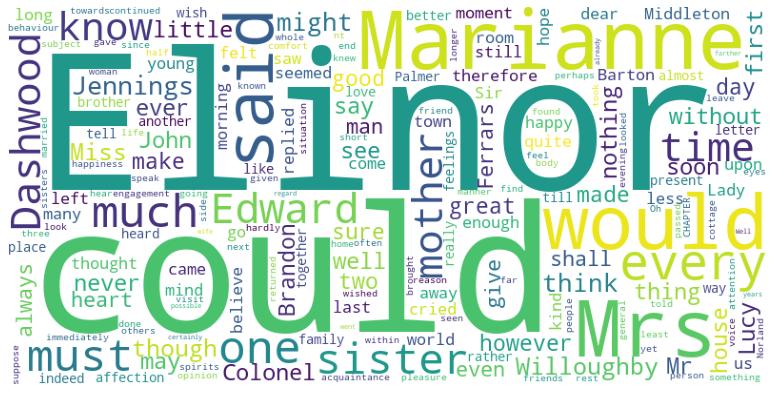

In [36]:
# 詞頻變成dict
freq_dict = freq_df.set_index('word', inplace=False).to_dict()
freq_dict = freq_dict['freq']

# 繪製文字雲
wordcloud = WordCloud(background_color='white',width=800, height = 400, max_words=200)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

使用上面做完詞性標記，並篩選名詞、動詞的資料(*pos_freq_df*)來繪製文字雲

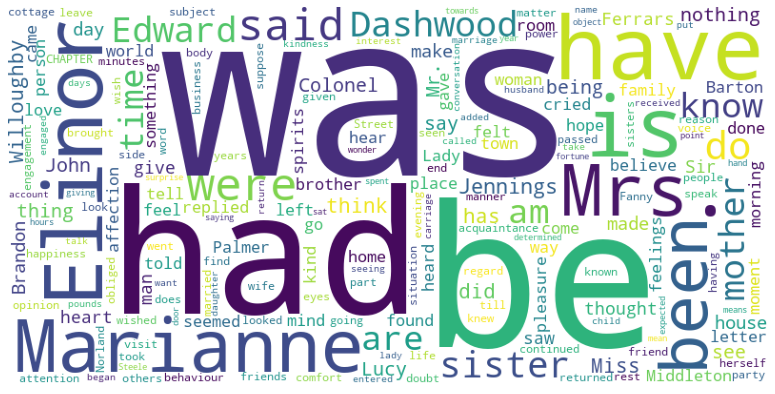

In [37]:
freq_dict = pos_freq_df.set_index('word', inplace=False).to_dict() ## 使用pos_freq_df 的資料
freq_dict = freq_dict['freq']

# 繪製文字雲
wordcloud = WordCloud(background_color='white',width=800, height = 400, max_words=200)
wordcloud.generate_from_frequencies(freq_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 繪製長條圖

<AxesSubplot:ylabel='word'>

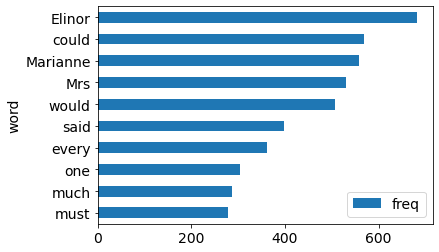

In [38]:

fre_plot = freq_df
fre_plot['freq'].astype(int) #將column轉integer
fre_plot = fre_plot.head(10).sort_values(by='freq', ascending=True)
fre_plot.plot(x='word',kind='barh') #bar垂直 barh水平

#### 依照各章節句數、與字數來計算長度，並繪製成折線圖

In [39]:
chapter_count = pd.DataFrame({
    'chapter': freq_sents.groupby('chapter').size().index,
    'sentences': freq_sents.groupby('chapter').size().values,
    'word': token_df.groupby('chapter').size().values,
})
chapter_count[:10]

,chapter,sentences,word
0,0,1,6
1,1,51,1568
2,2,101,1972
3,3,82,1545
4,4,91,1952
5,5,34,1025
6,6,45,1348
7,7,42,1295
8,8,63,1255
9,9,82,1866


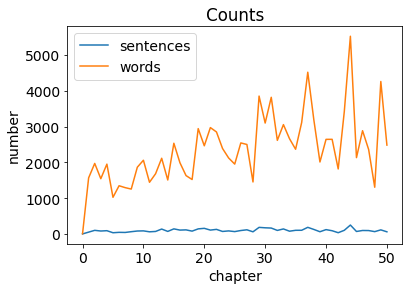

In [40]:
plt.plot(chapter_count['chapter'].values, chapter_count['sentences'].values ,label = 'sentences')
plt.plot(chapter_count['chapter'].values, chapter_count['word'].values, label = 'words')
plt.title('Counts') # 標題
plt.xlabel('chapter') # x軸標題
plt.ylabel('number') # y軸標題
plt.legend() # 顯示label
plt.show()

#### 比較前25回與後25回的詞彙差異

In [41]:
part_df = token_df.copy()
part_df.loc[ part_df.chapter <= 25, 'part'] = 'First25'
part_df.loc[ part_df.chapter > 25, 'part'] = 'Last25'
part_df

,word,chapter,part
1,Sense,0,First25
2,and,0,First25
3,Sensibility,0,First25
4,by,0,First25
5,Jane,0,First25
...,...,...,...
141370,between,50,Last25
141371,their,50,Last25
141372,husbands,50,Last25
141374,THE,50,Last25


In [42]:
# groupby「word」、「part」，計算次數
proportion_df = pd.DataFrame({
    'n':part_df.groupby(['word','part']).size(),
})

# 計算比例（除以總次數）
proportion_df['proportion'] = proportion_df['n']/sum(proportion_df['n'])

# pivot_table()
proportion_df = proportion_df.pivot_table(index='word', columns='part', values='proportion')
proportion_df = proportion_df.sort_values(by='First25', ascending=False)
proportion_df

part,First25,Last25
word,,
the,0.012871,0.019212
to,0.012498,0.021173
of,0.012331,0.017284
and,0.010944,0.016885
her,0.006805,0.013436
...,...,...
wrought,NaN,0.000008
wrung,NaN,0.000008
yew,NaN,0.000017


#### 比較前半跟後半詞彙

In [43]:
 # 將index reset
proportion_df = proportion_df.reset_index()
proportion_df = proportion_df.fillna(0) # 空值補零

# 移除停用字後
proportion_df = proportion_df[(proportion_df['word'].str.lower().isin(stop_words) == False)]

In [44]:
proportion_df['sub_last'] = proportion_df['First25'] - proportion_df['Last25'] # 前25回減後25回（前面比較常用，後面不常用）
proportion_df['sub_first'] = proportion_df['Last25'] - proportion_df['First25'] # 後25回減前25回（後面比較常用，前面不常用）
proportion_df

part,word,First25,Last25,sub_last,sub_first
28,Elinor,0.002061,0.003598,-0.001537,0.001537
35,Marianne,0.001820,0.002825,-0.001005,0.001005
36,would,0.001745,0.002468,-0.000723,0.000723
37,could,0.001737,0.002983,-0.001246,0.001246
39,said,0.001703,0.001595,0.000108,-0.000108
...,...,...,...,...,...
6834,wrought,0.000000,0.000008,-0.000008,0.000008
6835,wrung,0.000000,0.000008,-0.000008,0.000008
6836,yew,0.000000,0.000017,-0.000017,0.000017
6837,yielded,0.000000,0.000008,-0.000008,0.000008


#### 前25回常用、後25回不常用 vs 後25回常用、前25回不常用

/home/k8sn2/anaconda3/envs/workflow/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


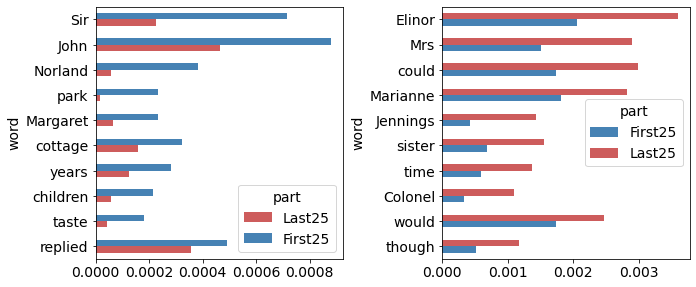

In [45]:
fig, axes = plt.subplots( nrows=1, ncols=2)

sub_last = proportion_df.sort_values('sub_last', ascending=True).tail(10)
sub_last.plot(x='word', y=['Last25', 'First25'], kind='barh', color=['indianred', 'steelblue'], ax=axes[0])

sub_first = proportion_df.sort_values('sub_first', ascending=True).tail(10)
sub_first.plot(x='word', y=['First25', 'Last25'], kind='barh', color=['steelblue', 'indianred'], ax=axes[1])

# 控制圖的間距
plt.subplots_adjust(top=1.0,left=0.125,right=1.5,wspace=0.4)

#### 前25回與後25回頻率一樣的詞彙

<AxesSubplot:ylabel='word'>

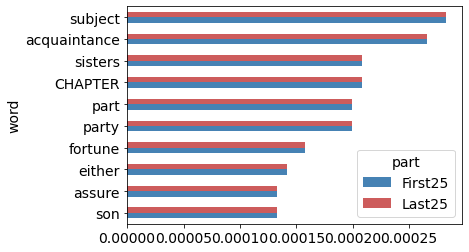

In [46]:
same = proportion_df[proportion_df['sub_first'] == 0].head(10).sort_values(by='First25',ascending=True)
same.plot(x='word', y=['First25', 'Last25'], kind='barh', color=['steelblue', 'indianred'])